In [12]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
import random
import csv

In [13]:
%load_ext PWE_NB_Extension

The PWE_NB_Extension extension is already loaded. To reload it, use:
  %reload_ext PWE_NB_Extension


In [14]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [15]:
def sql2clingo(sqlCommand,originalSchema,colour='black'):
    sql = sqlCommand.replace('"','')
    sqlList = sql.split(' ') 
    #print(sqlList)
    schemaList = originalSchema.split(',')
    #print(schemaList)
    clingoString = 0
    #print(sqlList[0])
    if sqlList[0] == 'UPDATE':
        sql = sql.replace(' = ','=')
        sql = sql.replace(' > ','>')
        sql = sql.replace(' < ','<')
        sql = sql.replace(' >= ','>=')
        sql = sql.replace(' <= ','<=')
        sql = sql.replace(',','')
        sqlList = sql.split(' ') 
        setLoc = sqlList.index('SET')
        whereLoc = sqlList.index('WHERE')
        setCommands = sqlList[setLoc+1:whereLoc]
        setCommands = [x.upper() for x in setCommands]
        whereCommands = sqlList[whereLoc+1:]
        whereCommands = [x.upper() for x in whereCommands if x != 'AND']
        whereCommandsString = '-'.join(whereCommands)
        whereCommandsComma = ','.join(whereCommands)
        setLocs = [x[:x.index('=')] for x in setCommands]
        setValues = [x[x.index('=')+1:] for x in setCommands]
        setVals = []
        startSetVals = []
        for x in (schemaList):
            if x in setLocs:
                loc = setLocs.index(x)
                setVals.append(setValues[loc])
                startSetVals.append('_')
            else:
                setVals.append(x)
                startSetVals.append(x)
        setValsString = ','.join(setVals)
        #clingoString = 'data('+setValsString+',black,"'+whereCommandsString+'",'+originalSchema+') :- data('+originalSchema+',_,_,_,_,_,_,_,_,_),'+whereCommandsComma+'.'
        clingoString = 'e(data('+setValsString+',prov(P,"'+whereCommandsString+'")),data('+originalSchema+',P),trans('+colour+',"'+whereCommandsString+'")) :- data('+originalSchema+',P),'+whereCommandsComma+'.'
    if sqlList[0] == 'INSERT':
        locator = 'VALUES('
        loc1 = sql.index(locator)
        loc2 = sql[loc1:].index(')')+loc1
        datavalues = sql[loc1+len(locator):loc2]
        datavaluesDash = datavalues.replace(',','-')
        clingoString = 'data('+datavalues+',"INSERT'+datavaluesDash+'").'
    
    return clingoString

In [16]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = []
    for x in dataValues:
        clingoStart.append('data('+','.join(x)+',"").')
    return clingoStart

In [17]:
def addConversion(dataValues):
    variables = []
    spaces = ['_']*len(dataValues)
    #underscores = ','.join(spaces)
        
    variables = [chr(65+x) for x in range(len(dataValues))]
    clingoHead = 'data('+','.join(variables)+',P) :-'
    clingoBody = 'e(data('+','.join(variables)+',P),data('+','.join(spaces)+',P),trans(_,T)).'
    
    
    return clingoHead+clingoBody

In [18]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [31]:
def cleanCSVFile(csv,outCSV):
    with open(csv,'r') as f:
        data = f.read()
    dataNew = data.replace('(','')
    dataNew2 = dataNew.replace(')','')
    with open(outCSV,'w') as f:
        f.write(dataNew2)
    print(dataNew2)

In [62]:
originalSchema = 'id,a0,a1,a2,a3,a4,a5'.upper()

In [32]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows1000_Nqueries10.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows1000_Nqueries10.csv']

In [33]:
testData = testDataNames[0]
testQueries = testQueryNames[0]

In [35]:
cleanCSVFile(testData,'testData.csv')
testData = 'testData.csv'

0, 13, 85, 77, 27, 52, 48
1, 65, 79, 11, 5, 85, 46
2, 76, 1, 46, 73, 26, 95
3, 91, 4, 4, 56, 95, 41
4, 21, 43, 4, 24, 46, 52
5, 23, 24, 23, 48, 32, 7
6, 84, 56, 65, 21, 100, 87
7, 12, 34, 73, 72, 94, 45
8, 83, 68, 32, 60, 89, 86
9, 51, 59, 5, 26, 81, 44


In [37]:
dataSet = []
with open(testData,'r') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ',quotechar='|')
    for row in reader:
        dataSet.append([' '.join(row)])

originalSetup = makeOriginal(dataSet)
#originalSchema = dataSet[0][0].upper()


In [39]:
# originalSchema = dataSet[0][0].upper()
# endSchema = originalSchema.replace(',',',END')
# end = 'END'
# endSchema = end + endSchema
# clingo_rules = ['% schema data('+originalSchema+',PROV)']
# clingo_rules.append(['% schema e(DATAEND,DATASTART,TRANS)'])

In [40]:
with open(testQueries,'r') as f:
    data = f.read()
#print(data)    
queries = data.split('\n')
#print(queries)

commands = []
for x in queries:
    clingoString = sql2clingo(x,originalSchema)
    if clingoString != 0:
        commands.append(clingoString)
        
#commands

In [41]:
ASPRules('\n'.join(commands))

'e(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46").\ndata(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(12,4,71,99,59,39,17,"INSERT12-4-71-99-59-39-17").\ne(data(ID,A0,95,27,A3,A4,A5,prov(P,"A1=96-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=96-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=96,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46").\ndata(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(12,4,71,99,59,39,17,"INSERT12-4-71-99-59-39-17").\ne(data(ID,A0,44,54,A3,A4,A5,prov(P,"A4>=24-A4<34-A2>=3-A2<13")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=24-A4<34-A2>=3-A2<13")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=24,A4<34,A2>=3,A2<13.\ndata(10,46,32,38,90,53,56,"INSERT10-46-32-38-90-53-56").\ndata(11,2,32,13,51,100,68,"INSERT11-2-32-13-51-100-68").\ndata(12,90,80,74,91,77,79,"INSERT12-90-80-74-91-77-79").\ne(data(ID,A0,16,97,A3,A4,A5,prov(P,"A4>=68-A4<78-A2>=65-A2<75")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=68-A4<78-A2>=65-A2<75")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=68,A4<78,A2>=65,A2<75.\ne(data(ID,A0,93,49,A3,A4,A5,prov(P,"A4>=45-A4<55-A2>=75-A2<85")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=45-A4<55-A2>=75-A2<85")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=45,A4<55,A2>=75,A2<85.\ne(data(ID,A0,46,90,A3,A4,A5,prov(P,"A4>=51-A4<61-A2>=83-A2<93")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=51-A4<61-A2>=83-A2<93")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=51,A4<61,A2>=83,A2<93.\ne(data(ID,A0,32,22,A3,A4,A5,prov(P,"A0=70-A2=16")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A0=70-A2=16")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A0=70,A2=16.\ne(data(ID,A0,31,92,A3,A4,A5,prov(P,"A0=96-A2=71")),data(ID,A0,A1,A2,A3,

In [42]:
ASPRules('\n'.join(originalSetup))

'data(0, 13, 85, 77, 27, 52, 48,"").\ndata(1, 65, 79, 11, 5, 85, 46,"").\ndata(2, 76, 1, 46, 73, 26, 95,"").\ndata(3, 91, 4, 4, 56, 95, 41,"").\ndata(4, 21, 43, 4, 24, 46, 52,"").\ndata(5, 23, 24, 23, 48, 32, 7,"").\ndata(6, 84, 56, 65, 21, 100, 87,"").\ndata(7, 12, 34, 73, 72, 94, 45,"").\ndata(8, 83, 68, 32, 60, 89, 86,"").\ndata(9, 51, 59, 5, 26, 81, 44,"").'

In [43]:
edgeNodeConv = addConversion(originalSchema.split(','))

In [44]:
ASPRules(edgeNodeConv)

'data(A,B,C,D,E,F,G,P) :-e(data(A,B,C,D,E,F,G,P),data(_,_,_,_,_,_,_,P),trans(_,T)).'

In [45]:
clingo_rules = ['% schema data('+originalSchema+',prov)','% schema e(DATAEND,DATASTART,TRANS)']
clingo_rules.extend(originalSetup)
clingo_rules.extend(commands)
clingo_rules.extend([edgeNodeConv])

In [46]:
#ASPRules('\n'.join(clingo_rules)) 

In [47]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\ndata(0,13,85,77,27,52,48,"") data(1,65,79,11,5,85,46,"") data(2,76,1,46,73,26,95,"") data(3,91,4,4,56,95,41,"") data(4,21,43,4,24,46,52,"") data(5,23,24,23,48,32,7,"") data(6,84,56,65,21,100,87,"") data(7,12,34,73,72,94,45,"") data(8,83,68,32,60,89,86,"") data(9,51,59,5,26,81,44,"") data(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46") data(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100") data(12,4,71,99,59,39,17,"INSERT12-4-71-99-59-39-17") data(10,46,32,38,90,53,56,"INSERT10-46-32-38-90-53-56") data(11,2,32,13,51,100,68,"INSERT11-2-32-13-51-100-68") data(12,90,80,74,91,77,79,"INSERT12-90-80-74-91-77-79") data(11,2,32,10,51,100,68,"INSERT11-2-32-10-51-100-68") data(10,64,87,52,74,67,6,"INSERT10-64-87-52-74-67-6") data(11,6,86,99,8,80,41,"INSERT11-6-86-99-8-80-41") data(12,29,77,88,4,62,4,"INSERT12-29-77-88-4-62-4") data(11,6,86,4,8,80,41,"INSERT11-6-86-4-8-80-41") data(10,82,4,4,63,28,53,"INSERT10-82-4-4-63-28-53") data(11,33,17,46,4,70,90,"INSERT11-33-17-46-4-70-90") e(data(8,67,68,32,60,16,86,prov("","A0>=78-A0<88-A4>=87-A4<97")),data(8,83,68,32,60,89,86,""),trans(black,"A0>=78-A0<88-A4>=87-A4<97")) e(data(1,59,79,11,5,91,46,prov("","A0>=62-A0<72-A4>=84-A4<94")),data(1,65,79,11,5,85,46,""),trans(black,"A0>=62-A0<72-A4>=84-A4<94")) e(data(5,23,59,65,48,32,7,prov("","A4>=28-A4<38-A2>=18-A2<28")),data(5,23,24,23,48,32,7,""),trans(black,"A4>=28-A4<38-A2>=18-A2<28")) e(data(0,13,93,49,27,52,48,prov("","A4>=45-A4<55-A2>=75-A2<85")),data(0,13,85,77,27,52,48,""),trans(black,"A4>=45-A4<55-A2>=75-A2<85")) e(data(12,90,16,97,91,77,79,prov("INSERT12-90-80-74-91-77-79","A4>=68-A4<78-A2>=65-A2<75")),data(12,90,80,74,91,77,79,"INSERT12-90-80-74-91-77-79"),trans(black,"A4>=68-A4<78-A2>=65-A2<75")) e(data(10,82,44,54,63,28,53,prov("INSERT10-82-4-4-63-28-53","A4>=24-A4<34-A2>=3-A2<13")),data(10,82,4,4,63,28,53,"INSERT10-82-4-4-63-28-53"),trans(black,"A4>=24-A4<34-A2>=3-A2<13")) e(data(4,21,78,52,24,46,52,prov("","A1>=35-A1<45-A4>=44-A4<54")),data(4,21,43,4,24,46,52,""),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) e(data(9,51,67,30,26,81,44,prov("","A1>=53-A1<63-A4>=80-A4<90")),data(9,51,59,5,26,81,44,""),trans(black,"A1>=53-A1<63-A4>=80-A4<90"))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.018s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.012s'

In [48]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False)

Number of Models: 1


In [49]:
#pw_rels_dfs.keys()
#edge_rel_name = 'data_16'

In [50]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_8'].applymap(turn_list_into_str)

In [51]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

startNode = []
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    if len(row['prov']) == 2:
        startNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')

In [52]:
startNodeNewformat = '\n'.join(startNode)

In [35]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeDict["start"] = [x for x in startNode]
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode

In [36]:
insertNodeNewformat = ['\n'.join(x) for x in insertNodeList]

In [11]:
#totNodes = []

In [53]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeDict["start"] = [x for x in startNode]
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode

In [54]:
provTraces = []
for i, row in pw_rels_dfs['e_3'].iterrows():
    provTraces.append(row['DATAEND'][-1][1:])
    
print(provTraces)
#uniqueProvTraces = set(provTraces)

[['""', '"A0>=78-A0<88-A4>=87-A4<97"'], ['""', '"A0>=62-A0<72-A4>=84-A4<94"'], ['""', '"A4>=28-A4<38-A2>=18-A2<28"'], ['""', '"A4>=45-A4<55-A2>=75-A2<85"'], ['"INSERT12-90-80-74-91-77-79"', '"A4>=68-A4<78-A2>=65-A2<75"'], ['"INSERT10-82-4-4-63-28-53"', '"A4>=24-A4<34-A2>=3-A2<13"'], ['""', '"A1>=35-A1<45-A4>=44-A4<54"'], ['""', '"A1>=53-A1<63-A4>=80-A4<90"']]


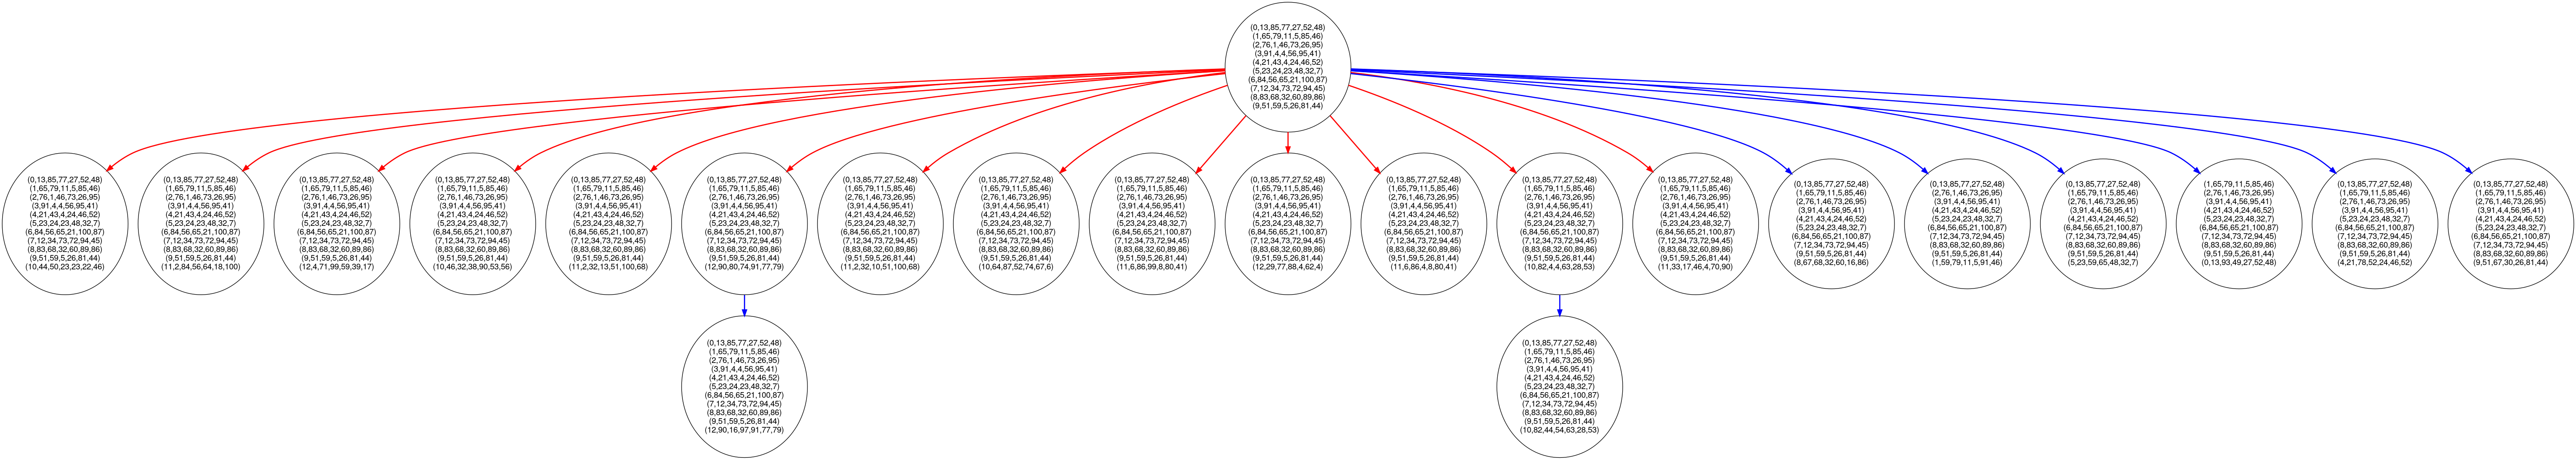

In [55]:
G = nx.DiGraph()
start = '\n'.join(startNode)
edges = []
provlist = []

for inserts in insertNodeList:
    endInsert = '\n'.join(inserts)
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert))
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    startNode2Ignore = []
    
    for i, row in pw_rels_dfs['e_3'].iterrows():
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            startNode2Ignore.append('('+"{}".format(','.join(row['DATASTART'][1:-1])+')'))
            startProv = row['DATASTART'][-1]

    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    startNodeSingle = nodeDict[startProv]
    endNodeBase = [x for x in nodeDict[startProv] if x not in startNode2Ignore]
    endNodeBase.extend(endNodeSingle)
    
    
    startNodeSingle = '\n'.join(startNodeSingle)
    endNodeSingle = '\n'.join(endNodeBase)
    nodeDict[prov[1]] = endNodeBase
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G,format='png',filename='qfixLarge.png')

In [56]:
start = nodeDict['start']
startNode = '\n'.join(start)

In [57]:
nodeKeys = list(nodeDict.keys())
targetNum = 10
targets = []
for x in range(targetNum):
    targets.append(random.randint(0,len(nodeDict)-1))

targetPos = [nodeDict[nodeKeys[x]] for x in targets]
targetNewFormat = ['\n'.join(t) for t in targetPos]

In [58]:
def getGraphStats(G,target,start):
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    allPaths.append(singlePath)
    APP = len(allPaths[0])
    
    allPSorted = sorted(allPaths[0])
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    
    return [APP,DIFFNUM,smallpp]

In [59]:
stats = getGraphStats(G,targetNewFormat[0],startNode)

In [60]:
statyBojangles = []
for x in targetNewFormat:
    statyBojangles.append(getGraphStats(G,x,startNode))

In [61]:
statyBojangles

[[1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [0, 0, 1],
 [1, 1, 2],
 [0, 0, 1]]